# Advanced Machine Learning Mid-Term Project
### Group E - Amaya Syed, Shane Richardson, Yong Chen Goh

In this project we aim to build and implement a deep neural network based classifier, and to subsequently attempt an adversarial attack on the classifier. The dataset we've chosen is a series of images of human retinas, with each image rated by a clinician based on the visible signs of Diabetic Retinopathy [1].

Report structure:
- Notebook initialization.
- Introduction.
- Resizing, importing, and splitting the data.
- Data exploration and visualization.
- Data augmentation.
- Neural network architecture.
- Training and testing.
- Analysis.
- Adversarial attacks.
- Further work.
- Conclusions.
- References.

Note that while it is possible to execute every cell in this notebook, it is not advisable, as the run-time would be significant. Some of the results shown here have been imported from other notebooks.

## Notebook Initialization

The most computationally demanding elements of our code were run on the GPUs provided for free by Google Colab (subject to some restrictions), the neural network training loop in particular. The following two cells should only be executed if using Google Colab. 

In [0]:
# Only needed when running on Google Colab.
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
# Only needed when running on Google Colab.
cd /drive/My Drive/Machine Learning

/drive/My Drive/Machine Learning


Here we load the necessary libraries, define a random seed, set the directory where the data and descriptive CSV file are stored in, and specify the settings for the 'matplotlib' library.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# General Python libraries.
import dill
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
sns.set()
from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import time

# PyTorch libraries.
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms

In [0]:
# Define random seed.
torch.manual_seed(0)

# Set directories.
DR_ROOT = os.path.abspath("./Data/")
DR_IMAGE_ORI = os.path.join(DR_ROOT, 'train_images')
DR_IMAGE_DIR = os.path.join(DR_ROOT, 'train_images_resized')
DR_LABEL_CSV = os.path.join(DR_ROOT, 'train.csv')

In [0]:
# Ensures matplotlib starts with default settings.
plt.style.use('default')

## Introduction

It is estimated that by 2040 approximately 642 million people will have diabetes [2]. Diabetic Retinopathy, the leading cause of blindness among working aged adults, is a complication of diabetes that slowly damages the retina and causes total loss of sight if left untreated. It's believed that 90% of new cases could be reduced with proper treatment and monitoring of the eyes [3]. Developing an efficient diagnostic algorithm would be a huge help to clinicians around the world, helping to unify diagnostic criteria as well as preventing patients from developing more severe symptoms.

Our data, a total of 3662 retinal images, was obtained via the "APTOS 2019 Blindness Detection" Kaggle synchronous Kernels-only competition [1]. Each image was rated by a clinician based on severity and then categorized into 5 classes:

0 - No sign of disease.

1 - Mild signs of disease.

2 - Disease in progression.

3 - Disease causing significant loss of sight.

4 - Loss of sight, either partial or total.

This is illustrated in the figure below.

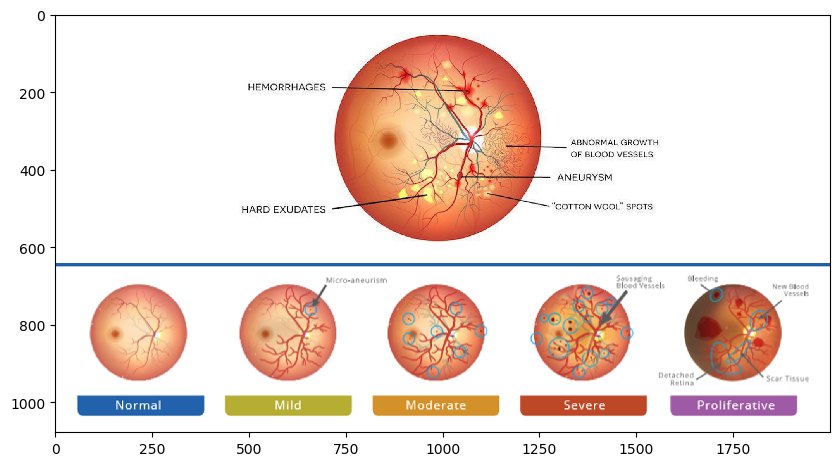

In [0]:
# Load an external image.
image = mpimg.imread("Diabetic_Retinopathy_Description.png")
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

While the progression of Diabetic Retinopathy seems relatively obvious in this idealised visual display, the reality is far more subtle, which presents challenges for classification. Indeed, even expert clinical practitioners struggle to achieve consensus. The figure below illustrates inconsistency both between different clinicians, and within a set of observations by the same clinician [4]. This inconsistency has obvious implications for any deep learning approach, if we are feeding our network with a ‘false’ signal then accurate classification becomes much more difficult.

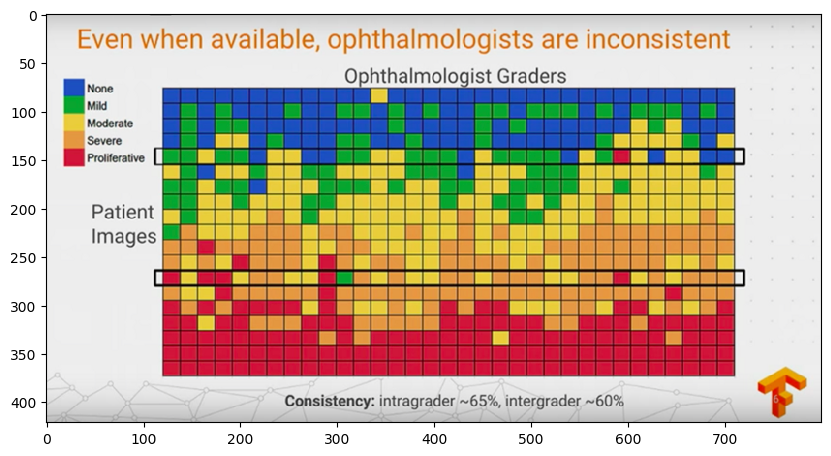

In [0]:
# Load an external image.
image = mpimg.imread("Inconsistent_Estimation.png")
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

We explore this problem by:
- Applying any necessary pre-processing to the input images.
- Splitting the available data into appropriate training and testing datasets.
- Passing the training data into a neural network based model for classification.
- Validating our network on the testing set.
- Implementing adversarial attack and defence.

## Resizing, Importing, and Splitting the Data

The full set of input images total 8 GB, which presented a significant computational challenge, and the individual images vary wildly in size. It was therefore necessary to resize the images to a more manageable (and uniform) size.

In [0]:
def Resizing(in_dir, out_dir, csv_file, transform):
    # Resize images to a size sepcified in 'transform'.
    # - in_dir = Location of input images.
    # - Out_dir = Desired location of the resized images.
    # - transform = Desired transforms to apply (in this case only resizing).
    
    # Read the CSV.
    CSV = pd.read_csv(csv_file)
    # Generate a list of 'id_code'.
    image_id_code = CSV['id_code'].tolist()
    # Generate a list of labels.
    image_diagnosis = CSV['diagnosis'].tolist()
    
    for i in range (len(CSV.id_code)):
        image_in_loc = os.path.join(in_dir, image_id_code[i] + '.png')
        image_out_loc = os.path.join(out_dir, image_id_code[i] + '.png')
        image1 = Image.open(image_in_loc)
        image2 = transform(image1)
        image2.save(image_out_loc)

In [0]:
# We define the transform operation, in this case a simple resizing.
resize = transforms.Compose([
        transforms.Resize((384, 384)),
    ])

In [0]:
Resizing(DR_IMAGE_ORI, DR_IMAGE_DIR, DR_LABEL_CSV, transform= resize)

Since our dataset comes from an external source (Kaggle), a custom data class is required if we wish to use the standard PyTorch DataLoader. After successfully resizing the images, we therefore define a custom Dataset class called RetinopathyDataset( ), and use the PyTorch DataLoader to load and access the resized images [5].

In [0]:
class RetinopathyDataset(Dataset):

    def __init__(self, main_dir, csv_file, transform):
        # Creates an instance of RetinopathyDataset.
        # Call as 'RetinopathyDataset(main_dir, csv_file, transform)'.
        self.main_dir = main_dir # Makes the 'main_dir' available to other functions in the class.
        self.transform = transform # Makes the chosen transforms available to other functions in the class
        
        self.CSV = pd.read_csv(csv_file) # Read the CSV.
        self.image_id_code = self.CSV['id_code'].tolist() # Generate a list of 'id_code'.
        self.image_diagnosis = self.CSV['diagnosis'].tolist() # Generate a list of labels.
        
    def __len__(self):
        # Returns the length of the dataset.
        # Call as 'len(dataset_name)'.
        return len(self.image_id_code)

    def __getitem__(self, idx):
        # Retrieves an element of the class, both the tensor and the label, returns as a tuple (tensor, label).
        # Call as 'dataset_name[i]'.
        image_loc = os.path.join(self.main_dir, self.image_id_code[idx] + '.png') # Define the image path.
        image = Image.open(image_loc) # Open the image. Or whether there are better options for opening.
        image_tensor = self.transform(image) # Apply transforms.
        
        image_label = self.image_diagnosis[idx] # Assign the label.
        
        return (image_tensor, image_label)

For the sake of benchmarking, we do not apply any other transformations to the data apart from passing it to a tensor structure.

In [0]:
# We can add to the transform list if needed but for now it's just the resizing and transformation to a tensor.
no_transforms = transforms.Compose([
        transforms.Resize(384),
        transforms.ToTensor(),
    ])

In [0]:
# Full input dataset.
full_dataset = RetinopathyDataset(DR_IMAGE_DIR, DR_LABEL_CSV, transform = no_transforms)

We create a function to split our data into training and testing sets.

In [0]:
def split_train_test(dataset, train_percent):
    # Set training percentage (and testing percentage, by extension).
    train_length = (train_percent * len(full_dataset)) // 100
    test_length = len(full_dataset) - train_length
    print(train_length)
    print(test_length)

    # Split the full input dataset into training and test datasets.
    train_dataset, test_dataset = random_split(full_dataset, [train_length, test_length])

    return train_dataset, test_dataset

We split our dataset into training (80%) and testing (20%) sets.

In [0]:
train, test = split_train_test(full_dataset, 80)

2929
733


Now we can load our data and specify each batch size.

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=0, drop_last=False)

In [0]:
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=0, drop_last=False)

## Data Exploration and Visualization

Before performing any further analysis, we need to understand more about our data. We investigate two main components:
- Class imbalance.
- Image features.

### Class Imbalance
Class imbalance is one of the most common problems in machine learning, where the total number of samples coming from a specific class greatly exceeds that from other classes. We want to investigate whether this behaviour is present in our dataset, and how severely it might affect our classifier.

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


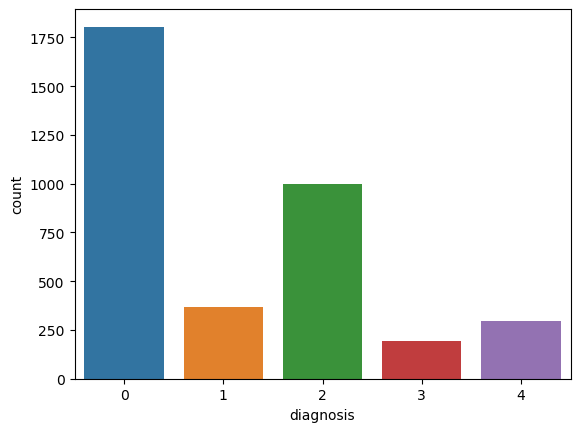

In [0]:
labels = pd.read_csv('./aptos2019-blindness-detection/train_images/train.csv')
print(labels['diagnosis'].value_counts())
sns.countplot(labels['diagnosis'])

As we can see above, almost 50% of the full dataset belong to class 0, and only 5% belong to class 3. 

Although class imbalance is fairly common in practice, several problems may arise if the disproportion is significant [6, 7]. In this case, for example, our algorithm could classify every image to class 0 and still get an accuracy level of approximately 50%. Possible ways to rectify this problem, or to improve the class imbalance include:

- **Resampling**: We can either "over-sample" or "under-sample". The former is where instances from under-represented classes (for example class 3) are duplicated, and the latter is where instances from over-represented classes (for example class 0) are removed.


- **Changing performance metrics**: Apart from accuracy levels, other metrics can be used to determine the robustness of our model. These include the use of Confusion Matrices, Area Under ROC (AUROC) Curves, Kappas, and many more.


- **Cost-Sensitive Training**: This method penalizes the algorithm by increasing the cost when minority classes are wrongly classified.

Now that we have investigated and discussed the significance of class imbalance within our dataset, we move on to image features.

### Image Features
We start by creating a sample batch to look at some of our images and their features (for example noise, exposure, focus, colour, etc) [8].

In [0]:
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch
print_images = sample_images[0:10]
print_labels = sample_labels[0:10]

labels: tensor([2, 2, 2, 2, 0, 0, 0, 3, 0, 2])


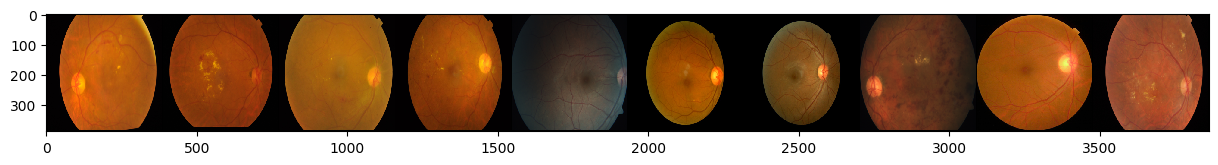

In [0]:
grid = torchvision.utils.make_grid(print_images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))
print('labels:', print_labels)

As we can see from these images, there is huge variability in the input images, in terms of intensity, cropping, hue, etc. One strategy to help our network perform better is **data augmentation**, which we explore in the next section.

## Data Augmentation 

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks [9].

There are many image augmentation packages readily available, however we implement our own by applying a few transformations to the images.

In [0]:
data_augmentation = transforms.Compose([
        transforms.Resize(384),
        transforms.ColorJitter(brightness=20., contrast= 0.2, hue= 0.4, saturation=20.), 
        transforms.RandomAffine(degrees=180, shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

We load our augmented data with our RetinopathyDataset() class, then split it into training and testing sets, as before. 

In [0]:
# Full input dataset.
augmented_dataset = RetinopathyDataset(DR_IMAGE_DIR, DR_LABEL_CSV, transform=data_augmentation)

In [0]:
train_aug, test_aug = split_train_test(augmented_dataset, 80)

2929
733


In [0]:
train_loader_aug = torch.utils.data.DataLoader(train_aug, batch_size=100, shuffle=True, num_workers=0, drop_last=False)

Now we can take a look at the augmented images.

In [0]:
sample_batch_aug = next(iter(train_loader_aug))
sample_images_aug, sample_labels_aug = sample_batch_aug
print_images_aug = sample_images_aug[0:10]
print_labels_aug = sample_labels_aug[0:10]

labels: tensor([0, 3, 0, 0, 0, 2, 0, 2, 0, 0])


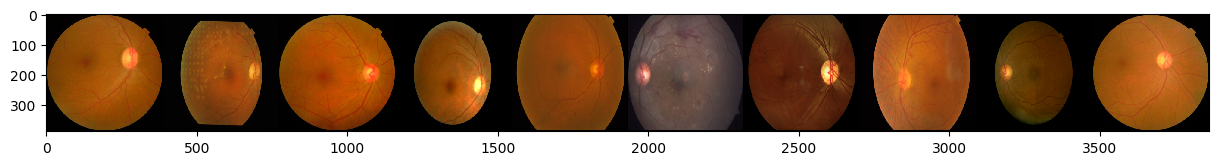

In [0]:
grid_aug = torchvision.utils.make_grid(print_images_aug, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid_aug.permute(1,2,0))
print('labels:', print_labels_aug)

We will train our network using this augmented training dataset, but will validate the trained network on the original testing set (i.e. with data that has not been augmented). 

# Neural Network Construction


  ## Convolutional networks

For high-dimensional inputs such as images, it is impractical to use fully connected layers, as this would be very computationally intensive. A more convenient solution is to use convolutional layers, which were designed to deal with two-dimensional image input (height x width) [10]. Here colour images are effectively treated as three images, one for each RGB colour channel, which is also known as the depth of the image. Convolution is a linear operation, whereby we perform a dot product between a three-dimentional set of weights - one for each image dimension, including depth - called filters or kernels, and the image input. 

The filter is designed to be smaller in size than the input and as the convolutional operation procedes, the filter sweeps across the whole image, obtaining a single value for each area and for each depth of the input covered by the filter. The value of the weights obtained for the same area on each RGB channel is then summed. The result of this operation is therefore a two-dimensional array of output values obtained from each area, which is called a feature map or "summed activation" and which acts as a summary of the information contained in the input. The mechanics of this operation for one RGB channel can be observed visually in the following image [11]:

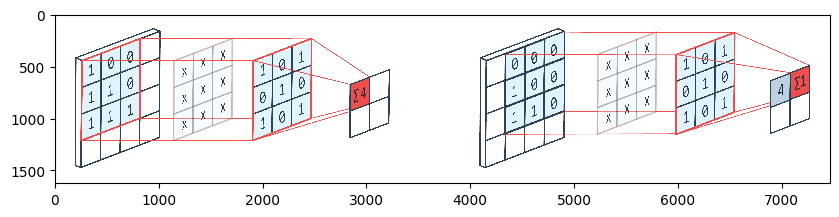

In [0]:
conv = mpimg.imread("conv.png")
plt.figure(figsize=(10,5))
plt.imshow(conv)
plt.show()

One of the consequences of repeatedly applying the same set of weights (aka filter) across the input is translational equivariance. Because the weights are shared across an the image, if any pattern or feature is detected it can be detected anywhere in the image, irrespective of its position. This is a very useful property, enabling better image classification [12]. It also reduces memory requirements, which opens the door to using input images of better quality and building deeper networks than one could using solely fully connected layers [12].

Each value of our feature map is then passed through a non-linear activation function, such as the Rectified linear unit or ReLU, which will transform the summed activation, depending on its value, into the activation or "firing" of the node. The nodes that are activated then act as the input in the next network layer, which is considered a hidden layer. Introducing this non-linear step at this stage is the crucial element which will enable the network to extract the relevant features for object classification. 

The activation function ReLU is a piecewise linear function that will output the input directly if it is positive and zero otherwise, with domain [0, $\infty$):

\begin{equation*}
f(x) = x^+ = max(0, x)
\end{equation*}


and where x is the input to a neuron. This function can be seen in the following graph [13]:

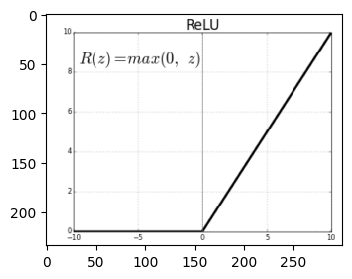

In [0]:
relu = mpimg.imread("Relu.png")
plt.figure(figsize=(6,3))
plt.imshow(relu)
plt.show()

Because this activation function is nearly linear, it preserves many properties that make linear models easy to optimize [14]. It has also been shown to yield equal or better results in finding local minima than the sigmoid or hyperbolic tangent functions, despite its  non-differentiability in zero [15]. The benefits of the ReLU function, as outlined in [15] includes creating a sparse representation of the neurons, with true zeros. This is closer to the biological functioning of neurons, which encode information in a sparse way, with only 1% to 4% active at any one time [15]. Furthermore, it is less computationally expensive than smooth activation functions. 

The output obtained from the activation layer can now be used as a final output, as the input for a further convolutional or linear layer or as the input for a pooling layer. Pooling layers downsample the input signal to a lower resolution signal via a pooling operation, which is analogous to applying a filter across the input. In  general that filter is 2 x 2 pixels in size, with a stride of 2, which has the effect of halving the signal and reducing the total feature map to a quarter of its original size [16]. Pooling filters can either average the values for each area covered on the feature map (average pooling) or keep the highest value (max pooling) [16]. Both techiques effectively summarize the information by focusing on the main features of the object. A very useful consequence of pooling layers is that of conferring the property of translational invariance to the network, as this summarizing of the information blurs the positional information of relevant feature, therefore giving the network the capacity to recognize these features despite potentially being in different locations than those the network was trained on.

After the pooling layer, our output is therefore a summarized version of the signal, which we can input into the next convolutional or linear layer of the network. The successive application of convolutional layer/activation function/pooling layer is what allows for the progressive extraction of the features which best permit object classification. The idea is that the first layer, which transforms the raw values of the pixels, might extract low level features, such as lines, whilst deeper layers might extract combined low level features which form shapes. This complexity and abstraction in the features extracted grows at each added layer the network. 

Then, as the network is trained and the weights of the filters are updated via forward and backward propagation, the features which minimize the loss for the classification task the network is being optimized for solve will automatically be extracted. Lastly the transformed input can be flatened and fed to a fully connected linear layer, which then feeds into a softmax classification layer, hence obtaining the final output corresponding to the class assigned to each image. 


### Neural Network architecture

The input to our network is a fixed, resized, 384 x 384 RGB image, normalized so that the pixel values are contained between [-1, 1]. As seen in the previous section, we choose to do no further pre-processing to the images, but do however use extensive data augmentation. 

We will now briefly explain the rationale behind our network architecture, whilst bearing in mind a part of it is due simply to trial and error. Overall, the architecture was closely based on the VGG11 network, but with maxpooling between every convolutional layer and less layers overall [17, 18, 19]. 

The first two convolutional layers have filters with a small receptive field of 3 x 3, with a convolutional stride fixed to 1 pixel to obtain a comprehensive subsampling of the input. The padding is set to 0 to overcome any border effect, therefore conserving our image input size [18]. The third convolutional layer has a slightly larger filter of 5 x 5, with other parameters the same, so as to potentially extract larger features. Between each convolutional layer we apply the ReLU activation function and maxpooling, to conserve the strongest signals and downsample our input. Each layer doubles its total out channels, a decision which was made by examining the structure of the VGG network architecture [17]. 

We then pass this output to two linear layers, each with a ReLU activation, before passing the output to the softmax layer for final classification into our five diagnostic categories.


## A note on Regularization

The final ingredient to our network was added after the first training run was completed with good classification accuracy on our training data (approx 98% accuracy), but relatively low accuracy on our testing data (approx 74% accuracy), therefore showing very clear signs of overfitting. 

We decided to investigate two regularization techniques, firstly dropout and secondly batch normalisation. We implemenented dropout in the fully connected linear layers, but this resulted in a drastic decrease in accuracy. In retrospect, the dropout probabilities used must have been too high, as we had seen in bibliography that the most effective rates were between 0.5 and 0.8. Possibly rates of dropout of 0.1 would have met with more success. 

Our second approach was to insert batch normalisation layers between each convolutional layers and before the non-linearity. This is not per se a regularization technique, but the bibliography indicates it does have a mild regularization effect. This approach was met with success, as in conjunction with the use of heavily augmented data, it reduced overfitting by 20 percent. Batch normalisation standardizes the activation values of each mini-batch so that it has a mean of zero and a standard deviation of one. This internal rescaling has the added benefit of allowing a more stable and efficient model training, as it seems it reparametrizes the underlying optimization problem to make its landscape significantly more smooth [20]. 

Our network class is kept in NetworkBatch 

In [0]:
class NetworkBatch(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        # "in-channels" for first convolutional layer equals to number of colour values
        # "out_features" for last linear layer equals to number of classes
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=60, kernel_size=3) # in_channels=3, out_channels=6, kernel_size=5
        self.conv1_nb = nn.BatchNorm2d(60)
        self.conv2 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3) # in_channels=6, out_channels=12, kernel_size=5
        self.conv2_nb = nn.BatchNorm2d(120)
        self.conv3 = nn.Conv2d(in_channels=120, out_channels=240, kernel_size=5)
        self.conv3_nb = nn.BatchNorm2d(240)

        self.fc1 = nn.Linear(in_features= 240 * 45 * 45, out_features= 120) # in_features=12*4*4, out_features=120
        self.fc2 = nn.Linear(in_features=120, out_features=60) # in_features=120, out_features=60
        self.out = nn.Linear(in_features=60, out_features=5) #in_features=60, out_features=5
        
    def forward(self, t):

        # 1st layer: convolution
        t = self.conv1(t)
        t = self.conv1_nb(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # 2nd layer: convolution 
        t = self.conv2(t)
        t = self.conv2_nb(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # 3rd layer: convolution 
        t = self.conv3(t)
        t = self.conv3_nb(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # flatten the input for the first linear layer. 
        t = t.view(t.size(0), -1) 

        # 4th layer: linear
        t = self.fc1(t)
        t = F.relu(t)
        
        # 5th layer: linear
        t = self.fc2(t)
        t = F.relu(t)
        
        # 6th layer: linear # maxAverage
        t = self.out(t)
        #t = F.softmax(t, dim=1) # softmax not necessary if using crossentropy loss function. 
        
        return t

## Loading the session variables using Dill

In [0]:
# This snippet of codes loads the colab workspace with all the variables obtained. We can look explore our results and variables. 
#dill.load_session('notebook_v14_v2.db')

## Training and Testing

Now that we have built our deep neural network, we can start the process of training our data. Our main chosen performance metric is the accuracy level. Thus, we create a function to calculate the prediction accuracy.

In [0]:
def accuracy(predictions, labels):
    accurate_outputs = predictions.argmax(dim=1).eq(labels).sum().item()
    accuracy_percentage = (accurate_outputs/len(labels))*100
    return accuracy_percentage

Next, we write a training function which will take our randomly **initialized neural network** weights, the **augmented training set**, a specified number of **epochs**, a chosen **optimizer**, and a suitable **step size** as inputs. 

Note that the number of epochs and step size are hyperparameters which are determined through trial-and-error. 

Our training loop then uses feed forward propagation to calculate the weights in each layer. The cost function which we want to optimise is the cross-entropy function, which uses the log-likelihood method to estimate its error.

Our optimizer is Adam - for adaptive moment estimation - which adapts the learning rate throughout the training loop based on the first two moments of the gradient [21]. Adam has been shown to have good convergence towards the local minima in a broad variety of problems and is computationally efficient, making it a good choice of optimizer. We use the default Pytorch settings for the optimizer.

Finally we use backward propagation to update our weights. We return the training accuracy, as well as the predicted labels and the training labels used. 


In [0]:
# The training loop
def training(network, train_loader, n_epochs, optimizer, step_size):
  
    time_start = time.time()
 

    running_loss = []
    running_training_accuracy = []
    running_training_accuracy.append(10)
    predicted_list = [] # Initialise list of predicted labels.
    labels_list = [] # Initialise list of correct labels.

    for epoch in range(n_epochs):

        training_accuracy = 0
        epoch_loss = 0

        for batch in train_loader:
            images, labels = batch
        
            optimizer.zero_grad()
            predictions = network(images)
        
            loss = F.cross_entropy(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            training_accuracy += accuracy(predictions, labels)

        running_loss.append(1/len(train_loader) * epoch_loss)    
        running_training_accuracy.append(1/len(train_loader) * training_accuracy)

        labels_list.extend(labels.tolist()) # Append next batch of labels
        predicted_list.extend(predictions.tolist()) # Append next batch of predicted labels.

        if (epoch + 1) % 2 == 0: 
            print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
                        %(epoch + 1, n_epochs, running_loss[epoch], running_training_accuracy[epoch + 1]))
            
    time_end = time.time()
    print("Training time in minutes = ", (time_end - time_start) / 60)

    return running_loss, running_training_accuracy, predicted_list, labels_list               


In [0]:
n_epochs = 40
step_size = 0.0001
network = NetworkBatch()
print(network)
optimizer = optim.Adam(network.parameters(), lr= step_size)
NetworkBatch_Adam = training(network, train_loader_aug, n_epochs, optimizer, step_size)
torch.save(network.state_dict(), 'trained_nn_norm_batch.pt')


```
NetworkBatch(
  (conv1): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (conv1_nb): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv2_nb): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(120, 240, kernel_size=(5, 5), stride=(1, 1))
  (conv3_nb): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=486000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=5, bias=True)
)
Epoch [2/40], Loss: 0.7203, Accuracy: 73.38 %
Epoch [4/40], Loss: 0.6243, Accuracy: 76.38 %
Epoch [6/40], Loss: 0.5283, Accuracy: 79.30 %
Epoch [8/40], Loss: 0.4264, Accuracy: 83.89 %
Epoch [10/40], Loss: 0.3270, Accuracy: 88.02 %
Epoch [12/40], Loss: 0.2362, Accuracy: 92.67 %
Epoch [14/40], Loss: 0.1969, Accuracy: 93.77 %
Epoch [16/40], Loss: 0.1555, Accuracy: 95.35 %
Epoch [18/40], Loss: 0.0967, Accuracy: 97.75 %
Epoch [20/40], Loss: 0.0987, Accuracy: 97.32 %
Epoch [22/40], Loss: 0.0863, Accuracy: 97.49 %
Epoch [24/40], Loss: 0.0572, Accuracy: 98.50 %
Epoch [26/40], Loss: 0.0552, Accuracy: 98.67 %
Epoch [28/40], Loss: 0.0597, Accuracy: 98.82 %
Epoch [30/40], Loss: 0.0588, Accuracy: 98.67 %
Epoch [32/40], Loss: 0.0554, Accuracy: 98.60 %
Epoch [34/40], Loss: 0.0474, Accuracy: 98.79 %
Epoch [36/40], Loss: 0.0539, Accuracy: 98.53 %
Epoch [38/40], Loss: 0.0380, Accuracy: 98.87 %
Epoch [40/40], Loss: 0.0541, Accuracy: 98.77 %
Training time in minutes =  228.10466052691143
```



## Analysis

In [0]:
# Load the network:
# - Create an empty instance of our network. Not sure if this is only necessary when loading the trained network model
# into a different notebook.
# - Load the stored network.
# - eval() is supposedly important when applying but still not sure why.
model = NetworkBatch()
model.load_state_dict(torch.load('trained_nn_norm_batch.pt'))
model.eval()

NetworkBatch(
  (conv1): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (conv1_nb): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv2_nb): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(120, 240, kernel_size=(5, 5), stride=(1, 1))
  (conv3_nb): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=486000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=5, bias=True)
)

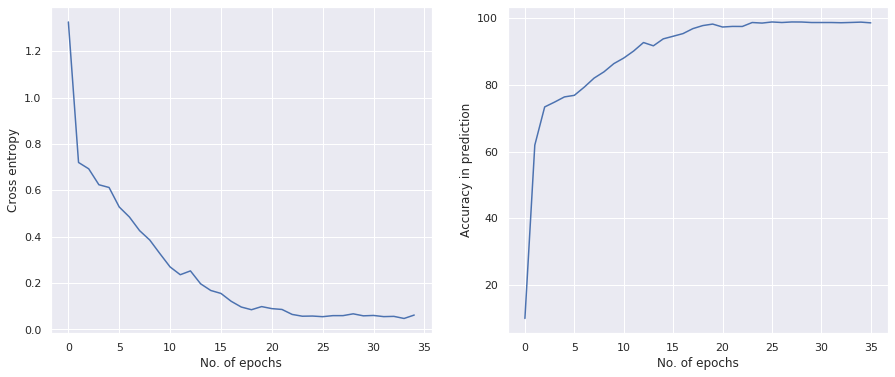

In [0]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(np.arange(n_epochs), NetworkBatch_Adam[0])
ax.set_xlabel('No. of epochs')
ax.set_ylabel('Cross entropy')

ax2.plot(np.arange(n_epochs + 1), NetworkBatch_Adam[1])
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy in prediction')

plt.savefig('loss.png') # I saved the file from the last on Drive 

In [0]:
def predict_and_evaluate(neural_network_model, Data_Loader):
    # Applies a trained neural network to images from Data_Loader. Returns:
    # - Accuracy as a percentage.
    # - The quadratic weighted kappa score.
    # - List of actual labels.
    # - List of predicted labels.
    
    correct = 0 # Initialise number of correct predictions.
    total = 0 # Initialise total number of predictions.
    
    labels_list = [] # Initialise list of correct labels.
    predicted_list = [] # Initialise list of predicted labels.
    
    with torch.no_grad():
        
        # Processes one batch at a time.
        for data in Data_Loader:

            images, labels = data
            outputs = model(images) # Apply our trained neural network to the images.
            _, predicted = torch.max(outputs.data, 1)
            labels_list.extend(labels.tolist()) # Append next batch of labels.
            predicted_list.extend(predicted.tolist()) # Append next batch of predicted labels.
            total = total + labels.size(0) # Increase by the size of the batch.
            correct = correct + (predicted == labels).sum().item() # Increase by the number of correct predictions.
    
    acc_per = (correct / total) * 100 # Calculate overall percentage accuracy.
    
    acc_qwk = cohen_kappa_score(labels_list, predicted_list, weights='quadratic') # Calculate quadratic weighted kappa accuracy.
    
    return acc_per, acc_qwk, labels_list, predicted_list

In [0]:
A, B, C, D = predict_and_evaluate(model, test_loader)

In [0]:
print('Test accuracy with augmented data', A, 'Quadratic Kappa Score', B)

Test accuracy with augmented data 93.99727148703957 Quadratic Kappa Score 0.9546115599023314


## Confusion Matrix

As mentioned earlier, another way to measure the network's performance, apart from accuracy levels, is by plotting a confusion matrix. A confusion matrix illustrates any 'confusion' between classes. In other words, it tells us whether a certain class was commonly mislabeled as a different class, resulting in false predictions. 

In [0]:
training_labels = NetworkBatch_Adam[3]
predicted_labels = NetworkBatch_Adam[2]

In [0]:
testing_length = np.shape(predicted_labels)[0]
predicted_class = []

for i in range(testing_length):
  predicted = np.argmax(predicted_labels[i])
  predicted_class.append(predicted)

In [0]:
results_test = confusion_matrix(C, D)
results_training = confusion_matrix(training_labels, predicted_class)

In [0]:
def plot_confusion_matrix(results):

    #matrix = results / np.sum(results, axis=0)

    fig = plt.figure()

    colors = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(results, annot=True, vmin= 0.0, vmax= 190., fmt='.3f', cmap= colors)

    plt.yticks([0.5,1.5,2.5, 3.5, 4.5], [ '0', '1', '2', '3', '4'], va='center')
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")

    plt.title('Confusion Matrix')

    plt.show()


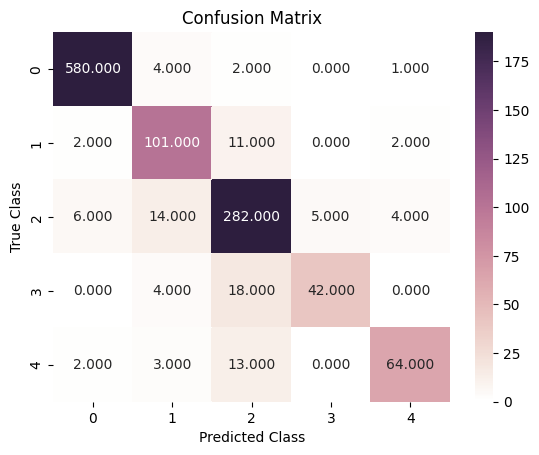

In [0]:
plot_confusion_matrix(results_training)

In [0]:
train_confusion_matrix = np.array([[580,4,2,0,1],[2,101,11,0,2],[6,14,282,5,4],[0,4,18,42,0],[2,3,13,0,64]])

Train_Recall = np.diag(train_confusion_matrix)/train_confusion_matrix.sum(1)
Train_Precision = np.diag(train_confusion_matrix)/train_confusion_matrix.sum(0)

# Calculating accuracy
print('Accuracy =', sum(np.diag(train_confusion_matrix))/train_confusion_matrix.sum()*100,'%')

# Calculating recall
print('Recall =', np.diag(train_confusion_matrix)/train_confusion_matrix.sum(1))

# Calculating precision
print('Precision =', np.diag(train_confusion_matrix)/train_confusion_matrix.sum(0))

# Calculating F-measure
print('F-measure =', 2*Train_Recall*Train_Precision/(Train_Recall+Train_Precision))

Accuracy = 92.15517241379311 %
Recall = [0.98807496 0.87068966 0.90675241 0.65625    0.7804878 ]
Precision = [0.98305085 0.8015873  0.86503067 0.89361702 0.90140845]
F-measure = [0.9855565  0.83471074 0.88540031 0.75675676 0.83660131]


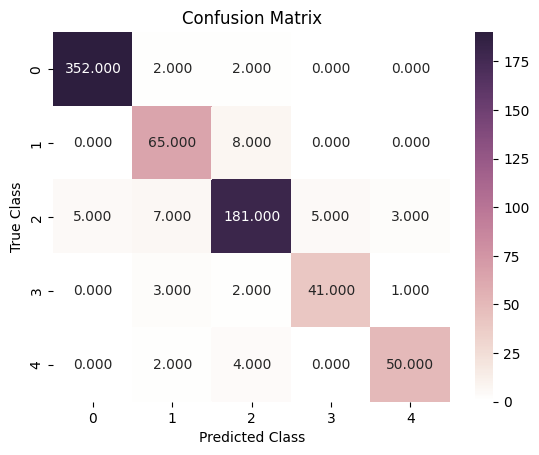

In [0]:
plot_confusion_matrix(results_test)

In [0]:
test_confusion_matrix = np.array([[352,2,2,0,0],[0,65,8,0,0],[5,7,181,5,3],[0,3,2,41,1],[0,2,4,0,50]])

Test_Recall = np.diag(test_confusion_matrix)/test_confusion_matrix.sum(1)
Test_Precision = np.diag(test_confusion_matrix)/test_confusion_matrix.sum(0)

# Calculating accuracy
print('Accuracy =', sum(np.diag(test_confusion_matrix))/test_confusion_matrix.sum()*100,'%')

# Calculating recall
print('Recall =', np.diag(test_confusion_matrix)/test_confusion_matrix.sum(1))

# Calculating precision
print('Precision =', np.diag(test_confusion_matrix)/test_confusion_matrix.sum(0))

# Calculating F-measure
print('F-measure =', 2*Test_Recall*Test_Precision/(Test_Recall+Test_Precision))

Accuracy = 93.99727148703957 %
Recall = [0.98876404 0.89041096 0.90049751 0.87234043 0.89285714]
Precision = [0.9859944  0.82278481 0.91878173 0.89130435 0.92592593]
F-measure = [0.98737728 0.85526316 0.90954774 0.88172043 0.90909091]


Based on the **testing set** confusion matrix and the above results, we can show the following:

**Accuracy** \
The accuracy is equal to the sum of diagonal elements over the sum of all elements, and is calculated to be 93.997271%.

**Recall** \
The recall of each Class i, i = 0,1,2,3,4, is defined as the total number of correctly classified examples for Class i divided by the total number of examples in Class i. This tells us what proportion of samples from Class i were correctly classified as Class i. 

Let us denote $R_i$ as the recall of Class i.

$R_0$ = 0.98876404 \
$R_1$ = 0.89041096 \
$R_2$ = 0.90049751 \
$R_3$ = 0.87234043 \
$R_4$ = 0.89285714 

We see that, unsurprisingly, Class 0 scored highest, whereas Class 3 scored lowest. This is likely due to the disproportion of samples from each class, with Class 0 being the majority and Class 3 the minority. This makes it easier to correctly classify samples from Class 0, and more difficult for Class 3.

**Precision** \
The precision is equal to the total number of correctly classified examples in Class i divided by the total number of predicted examples in Class i. This tells us, of all the samples which were predicted as Class i, what proportion truly belonged to Class i. 

Let us denote $Prec_i$ as the precision of Class i.

$Prec_0$ = 0.98599440 \
$Prec_1$ = 0.82278481 \
$Prec_2$ = 0.91878173 \
$Prec_3$ = 0.89130435 \
$Prec_4$ = 0.92592593

Class 1 scored lowest in this metric. This means that a larger proportion of samples were misclassified and thought to be in Class 1. Referring to the confusion matrix plot, we see that majority of the misclassified samples belonged to Class 2. This is in line with the fact that a larger proportion of samples from Class 1 were also misclassified as Class 2.

**F-measure** \
The F-measure is the harmonic mean of Recall and Precision. A poor F-Measure score is 0 and a perfect F-Measure score is 1.

Let us denote $F_i$ as the F-measure of Class i.

$F_0$ = 0.98737728 \
$F_1$ = 0.85526316 \
$F_2$ = 0.90954774 \
$F_3$ = 0.88172043 \
$F_4$ = 0.90909091

From this we can see that Class 0 has the best performance overall, scoring the highest for Recall, Precision and F-measure. Once again, this is unsurprising since majority of our dataset belongs to Class 0. 

## Adversarial Attacks

Neural networks can be exceptionally effective machine learning tools, but the irregular nature of their loss surfaces can make such networks especially vulnerable to adversarial attack (REF). We illustrate this using Fast Gradient Sign Attack (FGSM).

(REF) https://adversarial-ml-tutorial.org/adversarial_examples/

### Fast Gradient Sign Attack

The Fast Gradient Sign Attack (FGSM) is a relatively simple and computationally efficient means of attacking a neural network (23). The aim of the attack is to adjust the input data to maximise the loss, instead of attempting to minimize the loss by adjusting the weights using the back-propagated gradients (24). We take a 'step' in the direction of the maximum of the gradient, which can be summarised as:
$$\delta := \epsilon \times SIGN(\nabla J)$$
where
- $\delta$ is the perturbation to add to each image.
- $\epsilon$ is the magnitude of the perturbation, specified by the user/attacker.
- The $SIGN$ function is the standard mathematical expression returning either -1, 0, or 1.
- $\nabla$ J is the back-propagated gradient. 

The implementation below is largely derived from the 'Adversarial Example Generation' tutorial on the PyTorch website (24). The first step is to specify a list of $\epsilon$ values.

In [0]:
epsilons = [0, 0.0025, 0.0050, 0.0075, 0.010, 0.015, 0.020, 0.025]

We then define a function called 'attack_FGSM', which takes a test image and perturbs it in the direction of the gradient.

In [0]:
# FGSM attack code
def attack_FGSM(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

The 'attack_Test' function runs an attack on our classifier for a single value of $\epsilon$.

In [0]:
def attack_Test( model, loader, epsilon ):
    # Run an attack for a single value of 'epsilon'.

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for image, label in loader:

        # Set requires_grad attribute of tensor. Important for Attack
        image.requires_grad = True

        # Forward pass the data through the model
        output = model(image)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != label.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = image.grad.data

        # Call FGSM Attack
        perturbed_data = attack_FGSM(image, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == label.item():
            correct += 1
        
        # Save some adv examples for visualization later
        if len(adv_examples) < 100:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_ex = perturbed_data.squeeze().permute(1, 2, 0).detach().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In order to run attacks for multiple values of $\epsilon$ we simply loop over every entry in the 'epsilon' list defined earlier.

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_Test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 686 / 733 = 0.9358799454297408
Epsilon: 0.0025	Test Accuracy = 360 / 733 = 0.49113233287858116
Epsilon: 0.005	Test Accuracy = 174 / 733 = 0.2373806275579809
Epsilon: 0.0075	Test Accuracy = 127 / 733 = 0.17326057298772168
Epsilon: 0.01	Test Accuracy = 104 / 733 = 0.14188267394270124
Epsilon: 0.015	Test Accuracy = 77 / 733 = 0.10504774897680765
Epsilon: 0.02	Test Accuracy = 53 / 733 = 0.0723055934515689
Epsilon: 0.025	Test Accuracy = 38 / 733 = 0.05184174624829468


Plotting accuracy against $\epsilon$ (below) shows that our classification rate decreases in an exponential fashion as the magnitude of perturbation increases. While this general response is typical of an FGSM attack, the rate of decrease is a concern. There are two possible contributing factors:
- Our choice of network architecture is not particularly robust and resilient to adversarial attack.
- The images we are working with are relatively easy to perturb. Certainly the difference between individual classes is quite subtle, as discussed in the introduction. It would therefore make intuitive sense that a small perturbation is enough to change the classification of an image from one class to another.

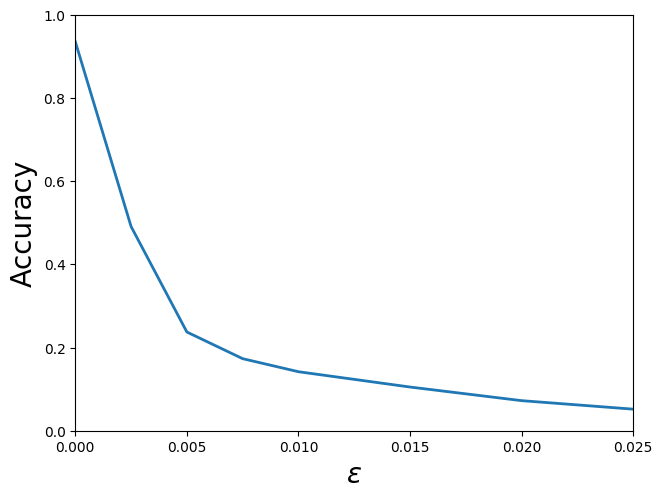

In [0]:
f = plt.figure(figsize=(7.2,5.4))
ax = f.add_subplot(111)

ax.plot(epsilons, accuracies, linewidth=2)
ax.set_xlabel('$\epsilon$', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)

ax.set_xlim(0, 0.025)
ax.set_ylim(0, 1)

plt.savefig('FGSM_Graph') 

The 'attack_images' function below extracts example images before and after adversarial attack.

In [0]:
def attack_images(perturbations, examples_array, example_number):
    # Display one example before and after adversarial attack, plus the difference.
    
    fig,ax = plt.subplots(1,3, figsize=(10, 10))
    
    # Input image.
    img1 = examples_array[0][example_number][2]
    
    # Image after adversarial attack.
    img2 = examples_array[7][example_number][2]
    
    # Difference image.
    temp0 = examples_array[7][example_number][2] - examples_array[0][example_number][2]
    temp1 = np.max(temp0) - np.min(temp0)
    img3 = temp0 / temp1 + 0.5
    
    # Set annotation and plot images.
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[2].imshow(img3)
    ax[0].set_title("Input")
    ax[1].set_title("$\epsilon$ = " + str(perturbations[7]))
    ax[2].set_title("Difference")
    ax[0].set_xlabel("CLASS " + str(examples_array[0][example_number][1]))
    ax[1].set_xlabel("CLASS " + str(examples_array[7][example_number][1]))
    
    plt.tight_layout()
    plt.show()

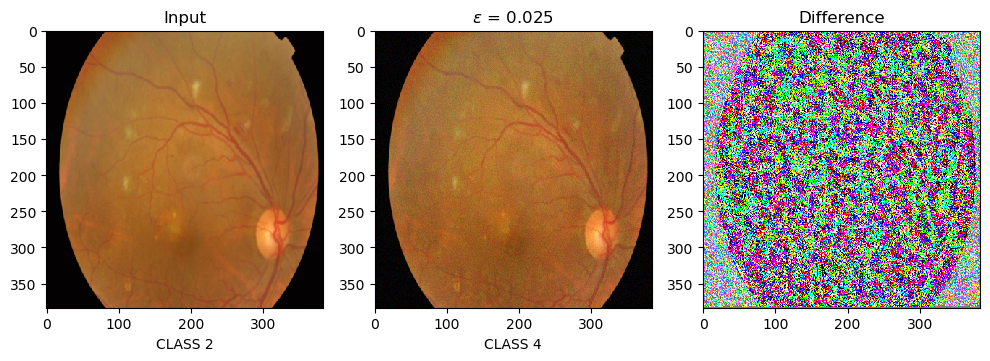

In [0]:
attack_images(epsilons, examples, 0)

We've chosen to extract an 'extreme' example because it's difficult to see much otherwise. The input image (left) is from Class 2 (a 'moderate' case of Diabetic Retinopathy). An FGSM attack using an $\epsilon$ value of 0.025 successfully perturbs this example into Class 4 ('proliferative' Diabetic Retinopathy). At this point our overall classification accuracy has dropped to approximately 5%, and yet the perturbed image (centre) looks very similar to the input image. The "Difference" image (right) shows some minimal evidence of structure, but for the most part the noise appears random. This illustrates the remarkable power of adversarial attacks in general (as per the famous Panda/Gibbon example [23]), and the FGSM attack in particular, because of:
- The relatively simple nature of the code involved.
- The low computational cost.

### Defending Our Network with Adversarial Training

Two widely discussed techniques for 'defending' a neural network against adversarial attacks are: 

- **Adversarial Training**: This is a technique where multiple adversarial examples are created and injected into the training data for increased robustness. (REF1)


- **Defensive Distillation**: This technique was first introduced by Hinton et al., where the model is trained to output probabilities of different classes (REF2). The probabilities are supplied by an earlier model, trained on the same task using hard class labels. (REF3)

The former will be applied. To do this, we simply create adversarial examples and incorporate them into the training process (REF4). In the following code we:
- Apply an FGSM perturbation to 20% of our training images, leaving the other 80% unchanged.
- Train our same (best) neural network on this combined dataset.
- Apply an FGSM attack to the new classifier.

20% was a somewhat arbitrary choice, but makes intuitive sense. We want our network to be as accurate as possible, and it seems likely that perturbing every image in the training dataset would lead to a decrease in classification accuracy. Ideally we would investigate this in a quantitative fashion, but computational restrictions limited our ability to explore this further.


(REF1) Ensemble Adversarial Training: Attacks and Defenses, F. Tramèr, A. Kurakin, N. Papernot, I. Goodfellow, D. Boneh, P. McDaniel, 2017 \
(REF2) Distilling the Knowledge in a Neural Network, Geoffrey Hinton, Oriol Vinyals, Jeff Dean, 2015 \
(REF3) https://openai.com/blog/adversarial-example-research/ \
(REF4) https://adversarial-ml-tutorial.org/adversarial_training/

Note that the 'attack_FGSM_2' function below differs slightly from the 'attack_FGSM' function introduced earlier. Both functions perform the same task, but use slightly different code. When this oversight was detected there wasn't time remaining to fix the problem.

In [0]:
# FGSM attack function.
# No modification yet.

def attack_FGSM_2(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

The 'training' function below has been slightly modified from the earlier version, with the changes clearly delineated. We apply an FGSM perturbation to 20% of the training images, using an $\epsilon$ value of 0.025, and pass the other 80% of the training images unaltered (perturbed using an $\epsilon$ value of 0.0, strictly speaking).

In [0]:
# The training loop
def training(network, train_loader, n_epochs, optimizer, step_size):
  
    time_start = time.time()

    running_loss = []
    running_training_accuracy = []
    running_training_accuracy.append(10)
    predicted_list = [] # Initialise list of predicted labels.
    labels_list = [] # Initialise list of correct labels.

    for epoch in range(n_epochs):

        training_accuracy = 0
        epoch_loss = 0

        for batch in train_loader:
            images, labels = batch
        
            optimizer.zero_grad()
            
#############################################################################################################
            # Added the following lines.
    
            # Use temp to only apply adversarial perturbation to 1 in 5 images.
            temp = np.random.randint(low=0, high=5)
            if temp == 0:
                delta = attack_FGSM_2(network, images, labels, 0.0025)
            else:
                delta = attack_FGSM_2(network, images, labels, 0.0)
                       
            # Modified the following line.
            predictions = network(images + delta)
#############################################################################################################
        
            loss = F.cross_entropy(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            training_accuracy += accuracy(predictions, labels)

        running_loss.append(1/len(train_loader) * epoch_loss)    
        running_training_accuracy.append(1/len(train_loader) * training_accuracy)

        labels_list.extend(labels.tolist()) # Append next batch of labels
        predicted_list.extend(predictions.tolist()) # Append next batch of predicted labels.

        if (epoch + 1) % 2 == 0: 
            print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
                        %(epoch + 1, n_epochs, running_loss[epoch], running_training_accuracy[epoch + 1]))
            
    time_end = time.time()
    print("Training time in minutes = ", (time_end - time_start) / 60)

    return running_loss, running_training_accuracy, predicted_list, labels_list               


In [0]:
n_epochs = 40
step_size = 0.0001

In [0]:
network = NetworkBatch()
print(network)
optimizer = optim.Adam(network.parameters(), lr= step_size)
FSGM = training(network, train_loader_aug, n_epochs, optimizer, step_size)
torch.save(network.state_dict(), 'Ad_Train_Test_1_trained_nn_norm_batch.pt')
dill.dump_session('notebook_v14_SR_09_Adversarial_training.db')



```
NetworkBatch(
  (conv1): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (conv1_nb): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv2_nb): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(120, 240, kernel_size=(5, 5), stride=(1, 1))
  (conv3_nb): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=486000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=5, bias=True)
)
Epoch [2/40], Loss: 0.7703, Accuracy: 71.88 %
Epoch [4/40], Loss: 0.7231, Accuracy: 73.55 %
Epoch [6/40], Loss: 0.6280, Accuracy: 76.16 %
Epoch [8/40], Loss: 0.5980, Accuracy: 78.05 %
Epoch [10/40], Loss: 0.5068, Accuracy: 80.59 %
Epoch [12/40], Loss: 0.4361, Accuracy: 83.21 %
Epoch [14/40], Loss: 0.3695, Accuracy: 86.12 %
Epoch [16/40], Loss: 0.2945, Accuracy: 89.86 %
Epoch [18/40], Loss: 0.3460, Accuracy: 87.56 %
Epoch [20/40], Loss: 0.2016, Accuracy: 92.92 %
Epoch [22/40], Loss: 0.2967, Accuracy: 88.92 %
Epoch [24/40], Loss: 0.2065, Accuracy: 93.14 %
Epoch [26/40], Loss: 0.1556, Accuracy: 94.84 %
Epoch [28/40], Loss: 0.1178, Accuracy: 96.27 %
Epoch [30/40], Loss: 0.1278, Accuracy: 96.03 %
Epoch [32/40], Loss: 0.0802, Accuracy: 97.95 %
Epoch [34/40], Loss: 0.1000, Accuracy: 96.75 %
Epoch [36/40], Loss: 0.0568, Accuracy: 98.33 %
Epoch [38/40], Loss: 0.1018, Accuracy: 96.25 %
Epoch [40/40], Loss: 0.1321, Accuracy: 95.37 %
Training time in minutes =  403.037499666214
```



Text(0, 0.5, 'Accuracy in prediction')

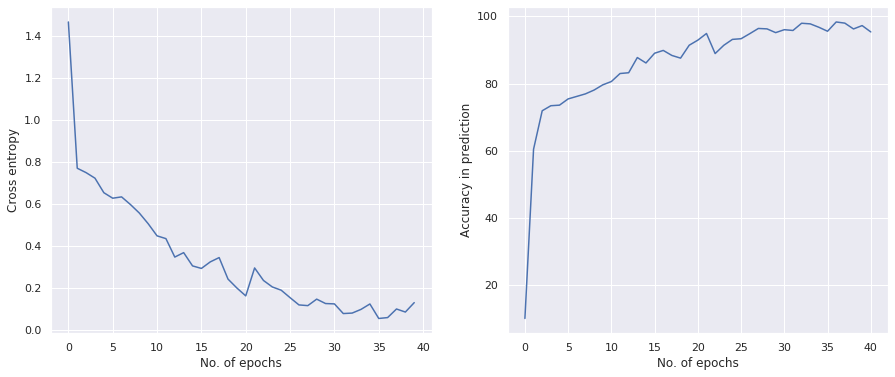

In [0]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(np.arange(n_epochs), FSGM[0])
ax.set_xlabel('No. of epochs')
ax.set_ylabel('Cross entropy')

ax2.plot(np.arange(n_epochs + 1), FSGM[1])
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy in prediction')

#plt.savefig('loss.png') # I saved the file from the last on Drive 

When comparing this newly trained classifier to the earlier network trained on the original, unperturbed images, we note:
- The loss doesn't appear to have stabilised after 40 epochs.
- The accuracy of this new classifier, when applied to the training dataset, has dropped from 98.79\% to approximately 95\%, and, like the loss, does not appear to have stabilised after 40 epochs.
- Training time approximately doubled.

We now apply the new classifier to our test dataset.

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons4:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    
dill.dump_session('notebook_v14_SR_02_FGSM_on_Ad_Trained_network.db')



```
Epsilon: 0	Test Accuracy = 684 / 733 = 0.9331514324693042
Epsilon: 0.0025	Test Accuracy = 642 / 733 = 0.8758526603001364
Epsilon: 0.005	Test Accuracy = 551 / 733 = 0.7517053206002728
Epsilon: 0.0075	Test Accuracy = 407 / 733 = 0.5552523874488404
Epsilon: 0.01	Test Accuracy = 279 / 733 = 0.3806275579809004
Epsilon: 0.015	Test Accuracy = 140 / 733 = 0.19099590723055934
Epsilon: 0.02	Test Accuracy = 80 / 733 = 0.10914051841746249
Epsilon: 0.025	Test Accuracy = 36 / 733 = 0.04911323328785812
```



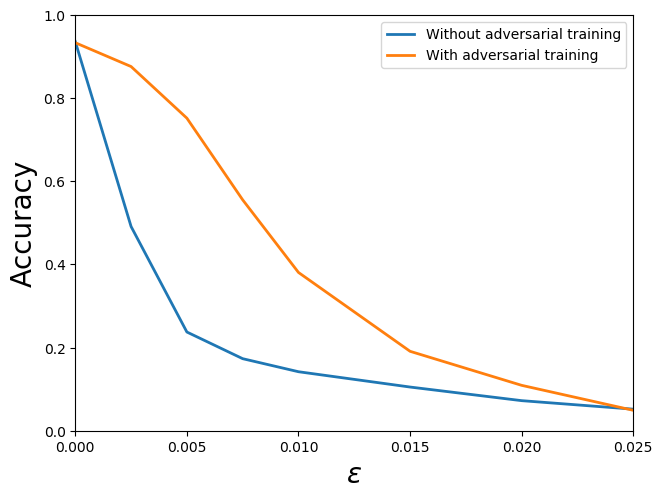

In [0]:
f = plt.figure(figsize=(7.2,5.4))
ax = f.add_subplot(111)

ax.plot(epsilons, accuracies1, linewidth=2, label="Without adversarial training")
ax.plot(epsilons, accuracies2, linewidth=2, label="With adversarial training")
ax.set_xlabel('$\epsilon$', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)

ax.set_xlim(0, 0.025)
ax.set_ylim(0, 1)

ax.legend(loc='upper right')

plt.savefig('FGSM_Graph') 

The plot above shows that Adversarial Training has improved the robustness of our classifier, but only slightly. What is encouraging, however, is that while training accuracy decreased from 98.77\% to 95.37\% (remembering the caveats discussed earlier), testing accuracy only decreased from 93.59\% to 93.32\%, effectively no change at all (within error bounds).

### Additional Adversarial Attack Techniques

Adversarial attack and defence is an extremely active area of research. Examples of other attack techniques include:
- Projected Gradient Descent (PGD) (REF1).
- Universal adversarial perturbation (REF2).
- A novel one pixel attack (REF3).
- The Adversarial Patch (REF5). This is a fascinating attack method that brings adversarial attack into the 'real' world. A small 'patch' is added to an image, whether a stored digital image, or added to a physical object as a printed patch. The addition of this patch can successfully fool image classifiers into reporting a chosen target class, regardless of the size of the patch and the nature of the other pixels in the image.
- The DeepFool algorithm (REF4).
- The Expectation Over Transformation (EOT) algorithm, which can generate adversarial examples even when images have been transformed (REF6).

We experimented with PGD on isolated examples, but ran into computational issues when trying to implement this on the full test dataset. This is essentially an iterative version of FGSM, using a smaller step size (REF1). PGD is a more effective algorithm than FGSM, but the iterative nature of the procedure does increase the computational cost. 

(REF1) https://adversarial-ml-tutorial.org/adversarial_examples/ \
(REF2) https://arxiv.org/pdf/1610.08401.pdf \
(REF3) https://arxiv.org/pdf/1710.08864.pdf \
(REF4) https://arxiv.org/pdf/1511.04599.pdf \
(REF5) https://arxiv.org/pdf/1712.09665.pdf \
(REF6) https://arxiv.org/pdf/1707.07397.pdf

## Further Work

The primary objectives of further work on this dataset would be:
- To reduce overfitting and better 'generalize' our neural network to new example images.
- To explore adversarial attack and defence in additional detail.

Techniques for reducing overfitting could include:
- Cross-validation. This is a standard technique in many different areas of mathematics, but was not implemented in this case because of computational limitations.
- Explore more robust architectures for our neural network.
- Look at sourcing additional data. An earlier Kaggle competition (in 2015) explored a similar problem, but with a much larger dataset (REF1). Training on this larger dataset should help to reduce overfitting in our model, but would also add computational cost. 
- Test the effect of selective data augmentation. In this investigation we augmented each class equally, but given the numerical inbalance between classes it might be worth exploring whether augmentation applied only to classes 1 to 4 has a positive impact on the level of overfitting.
- Explore 'pseudo-labelling' as another potential way to account for the class imbalance.

Adversarial attack and defence:
- Implement other attacks, possibly using some of the Python libraries that are now commonly available.
- Further investigate adversarial training.
- Explore other options for 'hardening' our neural network.

Other avenues of investigation:
- It would be interesting to see the performance of common pre-trained neural networks on this dataset, with the specific pre-processing and image size we have chosen. Possible choices representing a balance of speed and accuracy might be:
    - MobileNetV2 (REF2).
    - ResNet18 (REF3).
- Try to make a late submission to the competition! While it is now closed, the labels for the official test datset are yet to be released, and it appears late entrants are allowed. It would be interesting to see how well our code generalises to new data, as this was a common problem for other competitors. Competition entries were ranked according to the Quadratic Weighted Kappa score, which penalises incorrect classifications based on how 'far' the false classification is from the true label. So in this competition incorrectly classifying a class 0 image as class 4 would incur a greater penalty than a false classification of class 1. We achieved a Quadratic Weighted Kappa score for our test dataset of 0.945, which would have won us the competition if achieved on the official validation dataset! This result, however, must be taken with a pinch of salt, as generalizing trained models to new data proved exceptionally difficult for most competition entrants.

(REF1) https://www.kaggle.com/c/diabetic-retinopathy-detection/overview
(REF2) https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
(REF3) https://pytorch.org/hub/pytorch_vision_resnet/

## Conclusions

- With a relatively simple network we achieved classification accuracy of 98.77% on our training set.
- However, despite implementing regularization strategies, the model is still slightly overfitted, as we obtained only 93.59% accuracy on our testing set.
- Classification accuracy goes down very quickly under an FGSM attack. The design of the network does not seem very robust to external perturbations, even after incorporating adversarial training.

## References

[1] https://www.kaggle.com/c/aptos2019-blindness-detection/data
[2] K. Ogurtsova, J. da Rocha Fernandes, Y. Huang, U. Linnenkamp, L. Guariguata, N. Cho, D. Cavan, J. Shaw, L. Makaroff, Diabetes Res. Clin. Pract. 128, 40 (2017).
[3] R. Tapp, J. Shaw, C. Harper, M. de Courten, B. Balkau, D. McCarty, H. Taylor, T. Welborn, P. Zimmet, Diabetes Care 26, 1731 (2003). 
[4] https://medium.com/health-ai/ai-2-0-in-ophthalmology-googles-second-publication-c3b5390c19ae
[5] https://github.com/utkuozbulak/pytorch-custom-dataset-examples
[6] https://elitedatascience.com/imbalanced-classes
[7] https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
[8] https://deeplizard.com/learn/video/mUueSPmcOBc
[9] https://bair.berkeley.edu/blog/2019/06/07/data_aug/
[10] https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/
[11] https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/2d-convolution-block
[12] https://towardsdatascience.com/translational-invariance-vs-translational-equivariance-f9fbc8fca63a
[13] https://ailephant.com/glossary/relu-function/
[14] https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
[15] http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf
[16] https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
[17] https://arxiv.org/pdf/1409.1556.pdf
[18] http://cs231n.github.io/convolutional-networks/
[19] https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/
[20] https://arxiv.org/pdf/1805.11604.pdf
[21] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
[22] https://adversarial-ml-tutorial.org/adversarial_examples/
[23] https://arxiv.org/pdf/1412.6572.pdf 
[24] https://pytorch.org/tutorials/beginner/fgsm_tutorial.html 
[25] https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
[26] https://arxiv.org/pdf/1412.6572.pdf
[27] F. Tramèr, A. Kurakin, N. Papernot, I. Goodfellow, D. Boneh, P. McDaniel, Ensemble Adversarial Training: Attacks and Defenses (2017).
[28] G. Hinton, O. Vinyals, J. Dean, Distilling the Knowledge in a Neural Network (2015).
[29] https://openai.com/blog/adversarial-example-research/
[30] https://adversarial-ml-tutorial.org/adversarial_training/
[31] https://adversarial-ml-tutorial.org/adversarial_examples/
[32] https://arxiv.org/pdf/1610.08401.pdf
[33] https://arxiv.org/pdf/1710.08864.pdf
[34] https://arxiv.org/pdf/1511.04599.pdf
[35] https://arxiv.org/pdf/1712.09665.pdf
[36] https://arxiv.org/pdf/1707.07397.pdf
[37] https://www.kaggle.com/c/diabetic-retinopathy-detection/overview
[38] https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
[39] https://pytorch.org/hub/pytorch_vision_resnet/

